In [39]:
import zipfile
import os
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import Legend
output_notebook()

In [40]:
# Define paths
zip_path = "Datasets1.zip"
extract_path = "/content/datasets/"

# Extract ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# List extracted files
extracted_files = os.listdir(extract_path)
print("Extracted Files:", extracted_files)

Extracted Files: ['.ipynb_checkpoints', 'test.csv', 'ideal.csv', 'train.csv']


In [41]:
# Load CSV files into dataframes
dataframes = {}

for file in extracted_files:
    if file.endswith('.csv'):
        file_path = os.path.join(extract_path, file)
        df = pd.read_csv(file_path)
        dataframes[file] = df
        print(f"\n {file}:")
        print(df.head(), "\n")



 test.csv:
      x          y
0  17.5  34.161040
1   0.3   1.215102
2  -8.7 -16.843908
3 -19.2 -37.170870
4 -11.0 -20.263054 


 ideal.csv:
      x        y1        y2        y3        y4        y5        y6        y7  \
0 -20.0 -0.912945  0.408082  9.087055  5.408082 -9.087055  0.912945 -0.839071   
1 -19.9 -0.867644  0.497186  9.132356  5.497186 -9.132356  0.867644 -0.865213   
2 -19.8 -0.813674  0.581322  9.186326  5.581322 -9.186326  0.813674 -0.889191   
3 -19.7 -0.751573  0.659649  9.248426  5.659649 -9.248426  0.751573 -0.910947   
4 -19.6 -0.681964  0.731386  9.318036  5.731386 -9.318036  0.681964 -0.930426   

         y8        y9  ...        y41        y42       y43       y44  \
0 -0.850919  0.816164  ... -40.456474  40.204040  2.995732 -0.008333   
1  0.168518  0.994372  ... -40.233820  40.048590  2.990720 -0.008340   
2  0.612391  1.162644  ... -40.006836  39.890660  2.985682 -0.008347   
3 -0.994669  1.319299  ... -39.775787  39.729824  2.980619 -0.008354   
4  0.774356 

In [42]:
# Create SQLite database
db_path = "/content/analysis.db"
conn = sqlite3.connect(db_path)

# Store datasets in SQLite
for file, df in dataframes.items():
    table_name = file.replace(".csv", "")
    df.to_sql(table_name, conn, if_exists='replace', index=False)

print(" Data stored in SQLite database successfully!")


 Data stored in SQLite database successfully!


In [43]:
# Identifying the Best Ideal Functions
# Load training and ideal data
df_train = dataframes.get("train.csv")
df_ideal = dataframes.get("ideal.csv")

best_ideal_functions = {}

for train_col in df_train.columns[1:]:  # Skip x column
    min_sse = float('inf')
    best_func = None

    for ideal_col in df_ideal.columns[1:]:  # Skip x column
        sse = np.sum((df_train[train_col] - df_ideal[ideal_col]) ** 2)

        if sse < min_sse:
            min_sse = sse
            best_func = ideal_col

    best_ideal_functions[train_col] = best_func

print(" Best ideal functions mapping:", best_ideal_functions)


 Best ideal functions mapping: {'y1': 'y42', 'y2': 'y41', 'y3': 'y11', 'y4': 'y48'}


In [44]:
# Mapping of test to Ideal functions
df_test = dataframes.get("test.csv")
test_results = []

for index, row in df_test.iterrows():
    x_test, y_test = row['x'], row['y']
    best_match = None
    min_deviation = float('inf')

    for train_col, ideal_col in best_ideal_functions.items():
        y_ideal = df_ideal.loc[df_ideal['x'] == x_test, ideal_col].values
        if len(y_ideal) > 0:
            deviation = abs(y_test - y_ideal[0])
            if deviation < min_deviation:
                min_deviation = deviation
                best_match = ideal_col

    test_results.append((x_test, y_test, best_match, min_deviation))

# Store mapping results in SQLite
df_results = pd.DataFrame(test_results, columns=['x', 'y', 'ideal_function', 'deviation'])
df_results.to_sql('test_results', conn, if_exists='replace', index=False)

print(" Test data mapped and stored in SQLite!")


 Test data mapped and stored in SQLite!


In [45]:
# varifying data in SQLlite
print(pd.read_sql("SELECT * FROM test_results", conn))

       x          y ideal_function  deviation
0   17.5  34.161040            y41   0.351148
1    0.3   1.215102            y41   0.467342
2   -8.7 -16.843908            y41   0.887577
3  -19.2 -37.170870            y41   1.400790
4  -11.0 -20.263054            y41   1.236952
..   ...        ...            ...        ...
95  -1.9  -4.036904            y41   0.236246
96  12.2  -0.010358            y48   0.156869
97  16.5 -33.964134            y42   0.612934
98   5.3 -10.291622            y42   0.031191
99  17.9  28.078455            y41   7.314965

[100 rows x 4 columns]


In [46]:
# Vizualization of test data mapping

p = figure(title="Training Data vs. Ideal Functions", x_axis_label="X", y_axis_label="Y")

colors = ['red', 'green', 'blue', 'purple']
legend_items = []

for idx, (train_col, ideal_col) in enumerate(best_ideal_functions.items()):
    train_x = df_train['x']
    train_y = df_train[train_col]

    ideal_y = df_ideal[ideal_col]

    p.line(train_x, train_y, line_width=2, color=colors[idx], legend_label=f"Train {train_col}")
    p.line(train_x, ideal_y, line_width=2, color=colors[idx], line_dash="dashed", legend_label=f"Ideal {ideal_col}")

show(p)


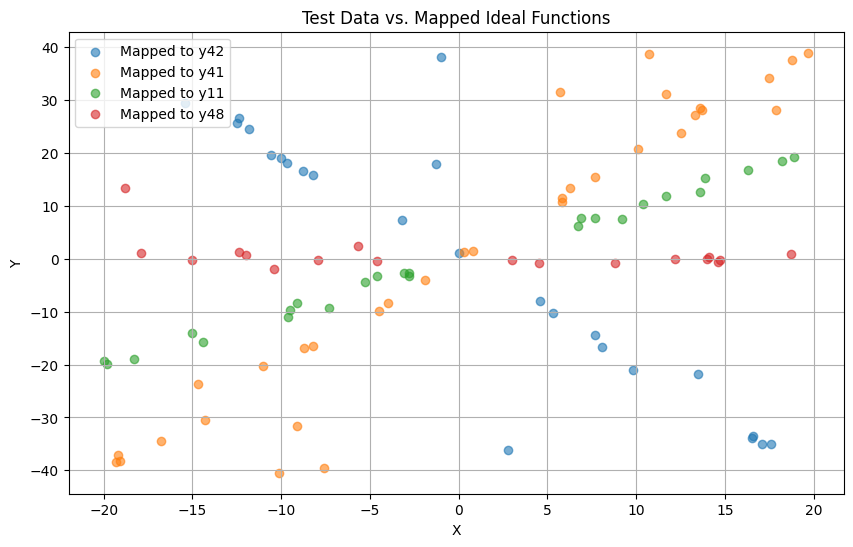

In [47]:
# Scatter Plot for test data vs mapped ideal functions
plt.figure(figsize=(10, 6))

for idx, (train_col, ideal_col) in enumerate(best_ideal_functions.items()):
    mapped_points = df_results[df_results['ideal_function'] == ideal_col]
    plt.scatter(mapped_points['x'], mapped_points['y'], label=f"Mapped to {ideal_col}", alpha=0.6)

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Test Data vs. Mapped Ideal Functions")
plt.legend()
plt.grid(True)
plt.show()


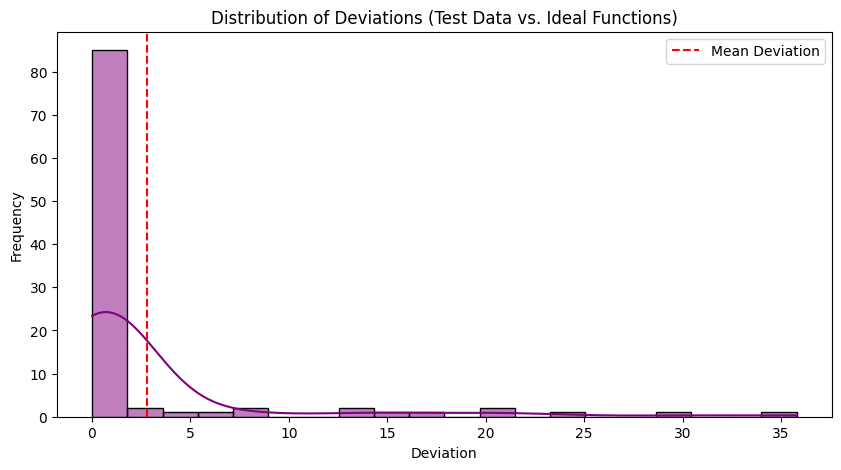

In [48]:
# Histogram plot for test data vs Ideal Functions
plt.figure(figsize=(10, 5))

sns.histplot(df_results['deviation'], bins=20, kde=True, color='purple')
plt.axvline(df_results['deviation'].mean(), color='red', linestyle="--", label="Mean Deviation")
plt.xlabel("Deviation")
plt.ylabel("Frequency")
plt.title("Distribution of Deviations (Test Data vs. Ideal Functions)")
plt.legend()
plt.show()


In [49]:
# Object-Oriented Approach
class DatabaseHandler:
    def __init__(self, db_path):
        self.conn = sqlite3.connect(db_path)

    def query(self, sql):
        return pd.read_sql(sql, self.conn)

class DataProcessor(DatabaseHandler):
    def get_training_data(self):
        return self.query("SELECT * FROM train")

    def get_ideal_functions(self):
        return self.query("SELECT * FROM ideal")

db_handler = DataProcessor(db_path)
df_train = db_handler.get_training_data()
df_ideal = db_handler.get_ideal_functions()


In [50]:
# Exception Handling
try:
    df_test = pd.read_sql("SELECT * FROM test", conn)
    if df_test.empty:
        raise ValueError("Test dataset is empty!")
except Exception as e:
    print(f"Error: {e}")


In [51]:
!git config --global user.email "your-email@example.com"
!git config --global user.name "Your Name"

In [52]:
!git clone -b develop https://github.com/your-repo.git


Cloning into 'your-repo'...
remote: Not Found
fatal: repository 'https://github.com/your-repo.git/' not found


In [53]:
!git add .
!git commit -m "Added new function"
!git push origin develop


fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
